In [82]:
import rasterio
import geopandas as gpd
import pyproj
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import lightgbm as lgbm
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from numpy import *
import numpy as np

In [83]:
def Sample(path, VH, VV, Ratio, Subtract, DEM, outdir):
    
    i=0
    for file in os.listdir(path):
        if file.endswith('shp'):

#            filename = file[3:7]
            points = os.path.join(path,file)
            pts = gpd.read_file(points)
            
            if i != 0:
                df_train = pd.concat([df_train,pts])
            else: 
                df_train = pts
                i=i+1  
                
    pts = df_train
    print(pts)
    coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]
    
    #VH Diff: Substract of VH from fall baseline median to target date VH. (fx march)
    #Ratio: VH divided with VV (or other way around, forgot)
    #Subtract: VH subtract with VV (or other way around, forgot)
    
    listofmasks=[VH, VV, Ratio, Subtract, DEM]
    listofmasksname=['VH', 'VV', 'Ratio', 'Subtract','DEM']
    
    i = 0
    for mask in listofmasks:
        src = rasterio.open(mask)
        pts[listofmasksname[i]] = [x[0] for x in src.sample(coords)]
        i=i+1
    pts = pts.drop(columns=['lats', 'lons', 'AT_dist'])    
    pts.to_file(outdir + 'SD.shp')
    return pts

In [84]:
sample_params = {
    'path' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/SnowDepth/',
    'VH' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/S1/VH.tif',
    'VV' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/S1/VV.tif',
    'Ratio' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/S1/Ratio.tif',
    #'VH_Diff' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/VH_Diff.tif',
    'Subtract' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/S1/Subtract.tif',
    'DEM': 'C:/Users/Rasmu/Documents/Thesis/DEM/mergedDEM10m_Hardanger_10m.tif',
    'outdir' : 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/Sampled/'
    }

In [85]:
pts = Sample(**sample_params)

     AT_dist     SD          lats           lons  \
0     9290.0  1.290  6.706440e+06  134427.679003   
1     9390.0  1.230  6.706342e+06  134407.215090   
2     9490.0  1.230  6.706195e+06  134376.982405   
3     9590.0  1.080  6.706195e+06  134376.982405   
4     9690.0  1.190  6.705988e+06  134333.909749   
..       ...    ...           ...            ...   
359  48900.0  1.760  6.668283e+06  119828.218466   
360  49000.0  1.695  6.668185e+06  119808.257957   
361  49100.0  1.700  6.668116e+06  119794.348479   
362  49200.0  1.570  6.667959e+06  119762.340098   
363  49300.0  1.570  6.667891e+06  119748.040371   

                           geometry  
0    POINT (134427.679 6706439.593)  
1    POINT (134407.215 6706342.141)  
2    POINT (134376.982 6706194.872)  
3    POINT (134376.982 6706194.872)  
4    POINT (134333.910 6705988.237)  
..                              ...  
359  POINT (119828.218 6668282.855)  
360  POINT (119808.258 6668185.083)  
361  POINT (119794.348 6668116.17

In [86]:
pts

,SD,geometry,VH,VV,Ratio,Subtract,DEM
0,1.290,POINT (134427.679 6706439.593),-19.101095,-9.513816,2.007722,-9.587280,1231.519775
1,1.230,POINT (134407.215 6706342.141),-18.927411,-9.423685,2.008494,-9.503726,1232.778076
2,1.230,POINT (134376.982 6706194.872),-18.688510,-9.146005,2.043352,-9.542505,1253.882812
3,1.080,POINT (134376.982 6706194.872),-18.688510,-9.146005,2.043352,-9.542505,1253.882812
4,1.190,POINT (134333.910 6705988.237),-18.352802,-8.707393,2.107726,-9.645409,1233.755981
...,...,...,...,...,...,...,...
359,1.760,POINT (119828.218 6668282.855),-17.741960,-9.898803,1.792334,-7.843156,1330.507812
360,1.695,POINT (119808.258 6668185.083),-17.907586,-9.926220,1.804069,-7.981366,1344.397705
361,1.700,POINT (119794.348 6668116.177),-17.948111,-10.011151,1.792812,-7.936961,1345.560425
362,1.570,POINT (119762.340 6667958.867),-18.316826,-10.021024,1.827840,-8.295803,1375.958618


In [87]:
def concat(AOI_path, outdir):
    
    #list of Training data samples
    lit = glob.glob(AOI_path + '*//Sampled//SD.shp')
    print('Training Data', lit)
    i = 0
    for item in lit:
        pts = gpd.read_file(item)
        if i != 0:
            df_train = pd.concat([df_train,pts])
        else: 
            df_train = pts
            i=i+1   
    df_train.to_file(outdir + 'SD_concat.shp')        
    return df_train

AOI_path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Training_Data/'

Training_Data = concat(AOI_path, outdir)

Training Data ['C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates\\20200306\\Sampled\\SD.shp', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates\\20200314\\Sampled\\SD.shp']


In [88]:
######################ONLY RUN WHEN ALL DATES ARE RUN SEPERATELY###############

In [89]:
def stack(path):
    VH = os.path.join(path , "VH.tif")
    VV = os.path.join(path , "VV.tif")
    Ratio = os.path.join(path , "Ratio.tif")
    #VH_Diff = os.path.join(path , "VH_Diff.tif")
    Subtract = os.path.join(path , "Subtract.tif")
    DEM =  'C:/Users/Rasmu/Documents/Thesis/DEM/mergedDEM10m_Hardanger_100m.tif'
    listofmasks=[VH, VV, Ratio, Subtract, DEM]
    print(listofmasks)
    
    lit_ravel = []
    i=0
    for rst in listofmasks:
        with rasterio.open(rst) as src:
            srcdata = src.read()
            print(srcdata.shape,'shape')
            ravel = srcdata[0].ravel()
            lit_ravel.append(ravel)
            profile = src.profile
            og_shape = srcdata.shape
            i=i+1
    
    print(len(lit_ravel))
    return lit_ravel, profile, og_shape

In [90]:
def model(Training_Data_Path, Prediction_Path, outdir, Binary_Mask): 
    
    pts = gpd.read_file(Training_Data_Path)
    X = pts.drop(columns=['SD', 'geometry'])
    y = pts['SD']
    #X = X.replace(np.nan, 0)     
    reg = lgbm.LGBMRegressor()
    reg.fit(X, y)
    #reg = RandomForestRegressor(max_depth=2, random_state=0).fit(X,y)
    importances = reg.feature_importances_
    print('importance', importances)
    
    lit_ravel, profile, og_shape = stack(Prediction_Path)
    
    X_test = np.transpose(lit_ravel)
    #X_test[np.isnan(X_test)] = 0 
    print(X.shape)
    print(X_test.shape)
    y_pred = reg.predict(X_test)  # make predictions
    print('modelling done')    

    #Predict on training to calc R2
    
    y_pred_train = reg.predict(X)
    #Calculate R2    
    r2 = r2_score(y, y_pred_train).round(2)
    r2 = format(r2, '.2f')
    print('r2', r2)
    
    with rasterio.open(Binary_Mask) as mask:
            srcdata = mask.read()
            B_Mask = srcdata[0].ravel()
    y_pred = y_pred * B_Mask        
    y_pred = y_pred.reshape(og_shape)
    
    with rasterio.open(outdir + 'Prediction_ArcticDEM4.tif', 'w', **profile) as dst:
        dst.write(y_pred.astype(rasterio.float32))
        
    return y_pred_train, y


Training_Data_Path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Training_Data/'
Prediction_Path = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200206/S1/'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Results/'
Binary_Mask = 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Masks/feb_2020_Binary_Mask.tif'
y_pred, y = model(Training_Data_Path, Prediction_Path, outdir, Binary_Mask)

importance [673 528 450 488 861]
['C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/VH.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/VV.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/Ratio.tif', 'C:/Users/Rasmu/Documents/Thesis/Hardangervidda/Dates/20200306/S1/Subtract.tif', 'C:/Users/Rasmu/Documents/Thesis/DEM/mergedDEM10m_Hardanger_100m.tif']
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
(1, 1206, 1550) shape
5
(3988, 5)
(1869300, 5)
modelling done
r2 0.81


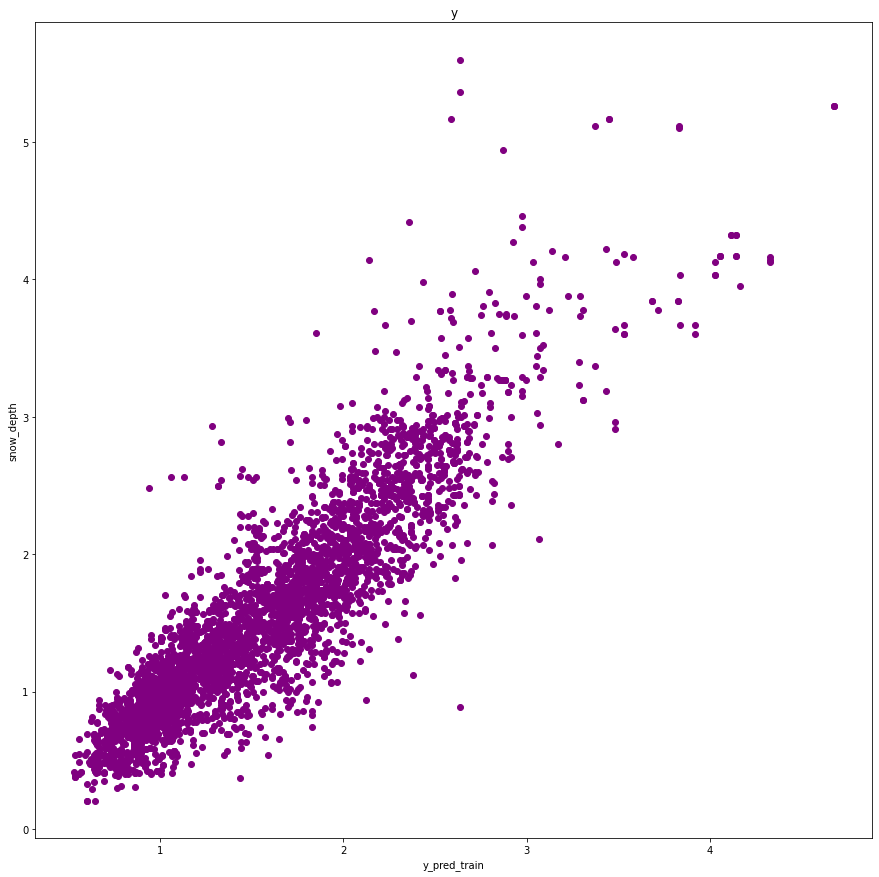

In [91]:
plt.figure(figsize=(15, 15))
plt.title('y')
plt.xlabel('y_pred_train')
plt.ylabel('snow_depth')
plt.scatter(y_pred, y, color='purple');
#plt.xlim([800, 1600])